<a href="https://colab.research.google.com/github/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/7%20-%20Rethinking%20Attention%20with%20Performers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 7 - Rethinking Attention with Performers

В этом разделе мы будем реализовывать версию модели Transformer под названием Peformer из статьи [Rethinking Attention with Performers](https://arxiv.org/abs/2009.14794).

Все изображения в этой части взяты из статьи Transformer. Для получения дополнительной информации о Transformer обращайтесь [сюда](https://www.mihaileric.com/posts/transformers-attention-in-disguise/), [сюда](https://jalammar.github.io/illustrated-transformer/) [и сюда](http://nlp.seas.harvard.edu/2018/04/03/attention.html). На русском языке [здесь](https://habr.com/ru/post/486358/).

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer1.png?raw=1)

## Введение

Подобно свёрточной модели Sequence-to-Sequence, Transformer не использует никакой рекуррентности. Он также не использует свёрточные слои. Вместо этого модель полностью состоит из линейных слоев, механизмов внимания и нормализации.

По состоянию на январь 2020 года трансформеры являются доминирующей архитектурой в NLP и используются для достижения передовых результатов во многих задач, и похоже, что они будут доминировать в ближайшем будущем в области обработки языков.

Самый популярный Transformer вариант это [BERT](https://arxiv.org/abs/1810.04805) (**B**idirectional **E**ncoder **R**epresentations from **T**ransformers) и предварительно обученные версии BERT обычно используются для замены слоёв эмбеддинга — если не больше - в NLP моделях.

Распространенной библиотекой, используемой при работе с предварительно обученными трансформаторами, является библиотека [Transformers](https://huggingface.co/transformers/), смотрите [здесь](https://huggingface.co/transformers/pretrained_models.html) список всех доступных предварительно обученных моделей.

Различия между реализацией в этой части и в статье:
- мы используем обученную позиционную кодировку вместо статической
- мы используем стандартный оптимизатор Adam со статической скоростью обучения вместо оптимизатора с динамически изменяющейся скоростью
- мы не используем сглаживание меток

Мы вносим все эти изменения, поскольку они близки к настройкам BERT и большинство вариантов Transformer используют аналогичную настройку.

In [ ]:
!pip install reformer_pytorch

In [13]:
import torch
from reformer_pytorch import ReformerLM
import torch.nn.functional as F

DE_SEQ_LEN = 4096
EN_SEQ_LEN = 4096

encoder = ReformerLM(
    num_tokens = 20000,
    emb_dim = 128,
    dim = 1024,
    depth = 12,
    heads = 8,
    max_seq_len = DE_SEQ_LEN,
    fixed_position_emb = True,
    return_embeddings = True # return output of last attention layer
).cuda()

decoder = ReformerLM(
    num_tokens = 20000,
    emb_dim = 128,
    dim = 1024,
    depth = 12,
    heads = 8,
    max_seq_len = EN_SEQ_LEN,
    fixed_position_emb = True,
    causal = True
).cuda()

x  = torch.randint(0, 20000, (1, DE_SEQ_LEN)).long().cuda()
yi = torch.randint(0, 20000, (1, EN_SEQ_LEN)).long().cuda()

enc_keys = encoder(x)               # (1, 4096, 1024)
yo = decoder(yi, keys = enc_keys)   # (1, 4096, 20000)
loss = F.cross_entropy(yo.tranpose(1, 2), yi[:, 1:])
loss.backward()

RuntimeError: ignored

## Подготовка данных

Как всегда, давайте импортируем все необходимые модули и зададим случайные начальные числа для воспроизводимости.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim

import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator, TabularDataset

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import spacy
import numpy as np

import random
import math
import time

In [ ]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

Для загрузки в Google Colab используем следующие команды (После загрузки обязательно перезапустите colab runtime! Наибыстрейший способ через короткую комаду： **Ctrl + M + .**):

In [ ]:
!pip install -U spacy==3.0
!python -m spacy download en_core_web_sm
!python -m spacy download de_core_news_sm

Затем мы создадим наши токенизаторы, как и раньше.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]


def tokenize_text(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in text.split(' ')]

Наши поля такие же, как и в предыдущих частях. Модель ожидает, что данные будут введены в первую очередь с размерностью батча, поэтому мы используем`batch_first = True`.

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Затем мы загружаем набор данных Multi30k и создаем словарь.

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))

In [ ]:
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

Наконец, мы определяем устройство для обучения и итератор данных.

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

## Построение модели

Далее мы построим модель. Как и в предыдущих частях, она состоит из *кодера* и *декодера*, с кодером *кодирующим* входное предложение (на немецком языке) в *вектор контекста* и декодера, который *декодирует* этот вектор контекста в выходное предложение (на английском языке).

### Кодировщик

Подобно модели ConvSeq2Seq, кодировщик Transformer не пытается сжать всё исходное предложение $X = (x_1, ... ,x_n)$ в единый вектор контекста $z$. Вместо этого он создает последовательность векторов контекста $Z = (z_1, ... , z_n)$. Итак, если бы наша входная последовательность состояла из 5 токенов, у нас было бы $Z = (z_1, z_2, z_3, z_4, z_5)$. Почему мы называем этот тензор последовательностью контекстных векторов, а не последовательностью скрытых состояний? Скрытое состояние в момент времени $t$ в RNN видит только токены x_t и все токены, что были перед ним. Однако здесь каждый вектор контекста `видел` все токены во всех позициях входной последовательности.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer-encoder.png?raw=1)

Сначала токены проходят через стандартный слой эмбеддинга. Поскольку модель не является рекуррентной, она не имеет представления о порядке токенов в последовательности. Мы решаем эту проблему, используя второй слой эмбеддинга, называемый *позиционный слой эмбеддинга* (positional embedding layer). Это стандартный эмбеддинг, для которого входом является не сам токен, а позиция токена в последовательности, начиная с первого токена, токена `<sos>` (начало последовательности) в позиции 0. Позиционный эмбеддинг имеет размер словаря, равный 100, что означает, что наша модель может принимать предложения длиной до 100 токенов. Его можно увеличить, если мы хотим обрабатывать более длинные предложения.

Оригинальная реализация Transformer в статье Attention is All You Need не обучала позиционный эмбеддинг. Вместо этого в ней использовался фиксированный статический эмбеддинг. Современные архитектуры Transformer, такие как BERT, вместо этого используют позиционные эмбеддинги, поэтому мы решили использовать их в этой реализации. Обратитесь [сюда](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding), чтобы узнать больше о позиционных эмбеддингах, используемых в исходной модели Transformer.

Затем токен и результат прохождения позиционного эмбеддинга поэлементно суммируются для получения вектора, который содержит информацию о токене, а также его позицию в последовательности. Однако перед суммированием токенов эмбеддинга они умножаются на коэффициент масштабирования, равный $\sqrt{d_{model}}$, где $d_{model}$ размер скрытого измерения `hid_dim`. Это якобы уменьшает дисперсию эмбеддинга, и модель трудно обучить без этого коэффициента масштабирования. Затем применяется дропаут для комбинированного эмебеддинга.

Комбинированный эмебеддинг затем пропускаются через $N$ *слоев кодировщика* для получения $Z$, для вывода и использования декодером.

Исходная маска `src_mask` просто имеет ту же форму, что и исходное предложение, но имеет значение 1, когда токен в исходном предложении не является токеном `<pad>` и 0, когда это токен `<pad>`. Это используется в слоях кодировщика для маскировки механизмов многонаправленного внимания, которые используются для вычисления и применения внимания к исходному предложению, поэтому модель не обращает внимания на токены `<pad>`, которые не содержат полезной информации.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim,
                                                  dropout, 
                                                  device) 
                                     for _ in range(n_layers)])
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        pos = torch.arange(0, src_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
        
        #pos = [batch size, src len]
        
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        #src = [batch size, src len, hid dim]
        
        for layer in self.layers:
            src = layer(src, src_mask)
            
        #src = [batch size, src len, hid dim]
            
        return src

### Слой кодировщика

Слои кодировщика — это место, содержащее всю «соль» кодировщика. Сначала мы передаем исходное предложение и его маску в *слой многонаправленного внимания*, затем выполняем дропаут для его выхода, применяем остаточное соединение и передайте его через [слой нормализации](https://arxiv.org/abs/1607.06450). Затем результат мы пропускаем через слой *сети позиционно-зависимого прямого распространения* и снова применяем дропаут, остаточное соединение, слой нормализации, чтобы получить вывод этого слоя, который передается на следующий слой. Параметры не разделяются (не являются общими) между слоями.

Слой многонаправленного внимания используется уровнем кодировщика для сосредоточения внимания на исходном предложению, то есть он вычисляет и применяет механизм внимание по отношению к себе, а не к другой последовательности, поэтому эту процедуру называются *внутренним вниманием*.

[Эта](https://mlexplained.com/2018/01/13/weight-normalization-and-layer-normalization-explained-normalization-in-deep-learning-part-2/) статья подробно рассказывает о нормализации слоев. Суть в том, что в процедуре нормализации нормализуются значения признаков (то есть по скрытым измерениям), поэтому каждый признак имеет среднее значение 0 и стандартное отклонение 1. Это упрощает обучение нейронных сетей с большим количеством слоев, таких как Transformer.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 
                
        #self attention
        _src, _ = self.self_attention(src, src, src, src_mask)
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        #positionwise feedforward
        _src = self.positionwise_feedforward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(_src))
        
        #src = [batch size, src len, hid dim]
        
        return src

### Слой многонаправленного внимания

Одна из ключевых, новых концепций, представленных в статье о Transformer, - это *слой многонаправленного внимания*.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer-attention.png?raw=1)

Внимание можно рассматривать как *запросы*, *ключи* и *значения* - где запрос используется с ключом для получения вектора внимания (обычно для вывода используется операция *softmax* и выходные величины имеют значения от 0 до 1, которые в сумме равны 1), используемый для получения взвешенной суммы значений.

Трансформер использует *масштабированное скалярное произведение внимания*, для которого *запрос* и *ключ* объединяются путем взятия скалярного произведения между ними, затем применяя операцию softmax и масштабируя $d_k$ прежде чем, наконец, умножить на *значение*. $d_k$ это *размер направления*, `head_dim`, которое мы раскроем далее.

$$ \text{Attention}(Q, K, V) = \text{Softmax} \big( \frac{QK^T}{\sqrt{d_k}} \big)V $$ 

Это похоже на стандартное *скалярное произведение для внимания*, но масштабируется по $d_k$, которое, как говорится в статье, используется, чтобы остановить результаты скалярных произведений, становящиеся большими, что приводит к тому, что градиенты становятся слишком маленькими.

Однако масштабированное скалярное произведение внимания применяется не просто к запросам, ключам и значениям. Вместо того, чтобы применять единственное внимание к запросам, ключам и значениям, их `hid_dim` разделить на $h$ *направлений* и масштабированное скалярное произведение внимания рассчитывается по всем направлениям параллельно. Это означает, что вместо того, чтобы уделять внимание одному понятию за одно применения внимания, мы обращаем внимание на $h$ понятий. Затем мы повторно объединяем направления в их `hid_dim` форму, таким образом, каждый `hid_dim` потенциально обращает внимание на $h$ разных понятий.

$$ \text{MultiHead}(Q, K, V) = \text{Concat}(\text{head}_1,...,\text{head}_h)W^O $$

$$\text{head}_i = \text{Attention}(QW_i^Q, KW_i^K, VW_i^V) $$

$W^O$ это линейный слой, применяемый в конце слоя внимания с несколькими направлениями, `fc`. $W^Q, W^K, W^V$ линейные слои `fc_q`, `fc_k` и `fc_v`.

Проходя по модулю, сначала вычисляем $QW^Q$, $KW^K$ и $VW^V$ с линейными слоями `fc_q`, `fc_k` и `fc_v`, дающие нам`Q`, `K` и `V`. Далее мы разбиваем `hid_dim` запроса, ключа и значения на `n_heads`, используя `.view` и правильно поменяв их порядок так, чтобы их можно было перемножить. Затем мы вычисляем `energy` (ненормализованное внимание) путем умножения `Q` и `K` вместе и масштабируя её на квадратный корень из `head_dim`, которое рассчитывается как `hid_dim // n_heads`. Затем мы маскируем энергию, чтобы не обращать внимания на элементы последовательности, на которые не следует сосредотачиваться, затем применяем softmax и дропаут. Затем мы применяем внимание к значениям направлений `V`, перед объединением `n_heads` вместе. Наконец, мы умножаем результат на $W^O$, представленное `fc_o`.

Обратите внимание, что в нашей реализации длины ключей и значений всегда одинаковы, поэтому при матричном умножении выход softmax, `attention`, с `V` у нас всегда будут правильного размера для умножения матриц. Это умножение выполняется с использованием `torch.matmul` который, когда оба тензора > 2-мерны, выполняет пакетное матричное умножение по последним двум измерениям каждого тензора. Это будет **[query len, key len] x [value len, head dim]** умножение матрицы на размер пакета и каждое направление, которая обеспечивает результат вида **[batch size, n heads, query len, head dim]**.

Поначалу кажется странным то, что дропаут применяется непосредственно к вниманию. Это означает, что наш вектор внимания, скорее всего, не будет суммироваться до 1, и мы можем уделять все внимание токену, но внимание к этому токену устанавливается на 0 в результате дропаута. Это никогда не объясняется и даже не упоминается в статье, однако используется в [официальное реализации](https://github.com/tensorflow/tensor2tensor/) и в каждой реализации Transformer, [включая BERT](https://github.com/google-research/bert/).

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
                
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
                
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = torch.matmul(Q, K.permute(0, 1, 3, 2)) / self.scale
        
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        attention = torch.softmax(energy, dim = -1)
                
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        
        #x = [batch size, query len, hid dim]
        
        return x, attention

### Слой позиционно-зависимого прямого распространения

Другой основной блок внутри уровня кодировщика — это *слой позиционно-зависимого прямого распространения*. Он устроен относительно просто по сравнению со слоем многонаправленного внимания. Вход преобразуется из `hid_dim` в `pf_dim`, где `pf_dim` обычно намного больше, чем `hid_dim`. Оригинальный Трансформер использовал `hid_dim` из 512 и `pf_dim` из 2048. Функция активации ReLU и дропаут применяются до того, как он снова преобразуется в представление `hid_dim`.

Почему он используется? К сожалению, в статье это нигде не объясняется.

BERT использует функцию активации [GELU](https://arxiv.org/abs/1606.08415), которую можно применить, просто переключив `torch.relu` на `F.gelu`. Почему они использовали GELU? Опять же, это никогда не объяснялось.

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        
        x = self.fc_2(x)
        
        #x = [batch size, seq len, hid dim]
        
        return x

### Декодер

Задача декодера — получить закодированное представление исходного предложения $Z$ и преобразовать его в предсказанные токены в целевом предложении $\hat{Y}$. Затем мы сравниваем $\hat{Y}$ с фактическими токенами в целевом предложении $Y$ для расчета потерь, которые будут использоваться для расчета градиентов параметров, а затем использованы в оптимизаторе для обновления весов с целью улучшить прогнозы.

![](https://github.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/blob/master/assets/transformer-decoder.png?raw=1)

Декодер похож на кодировщик, но в нём имеет два уровня внимания с несколькими направлениями. *Слой многонаправленного внимания с маскировкой* над целевой последовательностью и слоем многонаправленного внимания, который использует представление декодера в качестве запроса и представление кодера как ключ и значение.

Декодер использует позиционный эмбеддинг и комбинирование - через поэлементную сумму - с масштабированными целевыми токенами, прошедшими эмбеддинг, после чего следует дропаут. Опять же, наши позиционные кодировки имеют «словарь» равный 100, что означает, что они могут принимать последовательности длиной до 100 токенов. При желании его можно увеличить.

Комбинированные результаты эмбеддинга затем проходят через $N$ слоёв декодера, вместе с закодированным источником `enc_src`, а также исходной и целевой маской. Обратите внимание, что количество слоев в кодировщике не обязательно должно быть равно количеству слоев в декодере, даже если они оба обозначены как $N$.

Представление декодера после $N$-го слоя затем пропускается через линейный слой `fc_out`. В PyTorch операция softmax содержится в нашей функции потерь, поэтому нам не нужно явно использовать здесь слой softmax.

Помимо использования исходной маски, как мы это делали в кодировщике, чтобы наша модель не влияла на токен `<pad>`, мы также используем целевую маску. Это будет объяснено далее в `Seq2Seq` модели, которая инкапсулирует как кодер, так и декодер, но суть ее в том, что она выполняет ту же операцию, что и заполнение декодера в свёрточной модели sequence-to-sequence model. Поскольку мы обрабатываем все целевые токены одновременно и параллельно, нам нужен метод остановки декодера от «обмана», просто «глядя» на следующий токен в целевой последовательности и выводя его.

Наш слой декодера также выводит нормализованные значения внимания, чтобы позже мы могли построить их график, чтобы увидеть, на что на самом деле обращает внимание наша модель.

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        
        pos = torch.arange(0, trg_len).unsqueeze(0).repeat(batch_size, 1).to(self.device)
                            
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
                
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        
        #output = [batch size, trg len, output dim]
            
        return output, attention

### Слой декодера

Как упоминалось ранее, уровень декодера аналогичен уровню кодера, за исключением того, что теперь он имеет два уровня многонаправленного внимания `self_attention` и `encoder_attention`.

Первый, как и в кодировщике, осуществляет внутреннее внимание, используя представление декодера, вплоть до запроса, ключа и значения. Затем следует дропаут, остаточное соединение и слой нормализации. Этот слой `self_attention` использует маску целевой последовательности `trg_mask`, чтобы предотвратить «обман» декодера, обращая внимание на токены, которые «опережают» тот, который он обрабатывает в настоящее время, поскольку он обрабатывает все токены в целевом предложении параллельно.

Второй определяет как мы на самом деле подаём закодированное исходное предложение `enc_src` в наш декодер. В этом слое многонаправленного внимания запросы являются представлениями декодера, а ключи и значения — представлениями кодировщика. Здесь исходная маска `src_mask` используется для предотвращения того, чтобы слой многонаправленного внимания обращал внимание на токен `<pad>` в исходном предложении. Затем следуют уровни дропаута, остаточного соединения и уровень нормализации.


Наконец, мы передаем результат через слой позиционно-зависимого прямого распространения и еще одна последовательность дропаута, остаточного соединения и уровень нормализации.

Слой декодера не вводит никаких новых концепций, просто использует тот же набор слоев, что и кодировщик, но немного по-другому.

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        _trg, _ = self.self_attention(trg, trg, trg, trg_mask)
        
        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(_trg))
            
        #trg = [batch size, trg len, hid dim]
            
        #encoder attention
        _trg, attention = self.encoder_attention(trg, enc_src, enc_src, src_mask)
        
        #dropout, residual connection and layer norm
        trg = self.enc_attn_layer_norm(trg + self.dropout(_trg))
                    
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        _trg = self.positionwise_feedforward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(_trg))
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

### Seq2Seq

Наконец, у нас есть модуль `Seq2Seq`, который инкапсулирует кодировщик и декодер, а также управляет созданием масок.

Исходная маска создается путем проверки того, что исходная последовательность не равна токену `<pad>`. Это 1, когда токен не является токеном `<pad>`, и 0, когда он является этим токеном. Затем он "разжимается", чтобы его можно было правильно транслировать при наложении маски на `energy`, которая имеет форму **_[batch size, n heads, seq len, seq len]_**.

Целевая маска немного сложнее. Сначала мы создаем маску для токенов `<pad>`, как мы это делали для исходной маски. Далее, мы создаем «последующую» маску, `trg_sub_mask`, используя `torch.tril`. Таким образом создаётся диагональная матрица, в которой элементы над диагональю будут равны нулю, а элементы под диагональю будут установлены на любой входной тензор. В этом случае входным тензором будет тензор, заполненный единицами. Это означает, что наша `trg_sub_mask` будет выглядеть примерно так (для цели с 5 токенами):

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

Это показывает, на что может смотреть каждый целевой токен (строка) (столбец). Первый целевой токен имеет маску **_[1, 0, 0, 0, 0]_**, что означает, что он может смотреть только на первый целевой токен. Второй целевой токен имеет маску **_[1, 1, 0, 0, 0]_**, что означает, что он может просматривать как первый, так и второй целевые токены.

Затем «последующая» маска логически дополняется маской заполнения, которая объединяет две маски, гарантируя, что ни последующие токены, ни маркеры заполнения не могут быть обработаны. Например, если бы последние два токена были токенами `<pad>`, маска выглядела бы так:

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

После того, как маски созданы, они используются с кодировщиком и декодером вместе с исходным и целевым предложениями, чтобы получить наше предсказанное целевое предложение, «output», вместе с вниманием декодера к исходной последовательности.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        
        #src = [batch size, src len]
        
        src_mask = (src != self.src_pad_idx).unsqueeze(1).unsqueeze(2)

        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):
        
        #trg = [batch size, trg len]
        
        trg_pad_mask = (trg != self.trg_pad_idx).unsqueeze(1).unsqueeze(2)
        
        #trg_pad_mask = [batch size, 1, 1, trg len]
        
        trg_len = trg.shape[1]
        
        trg_sub_mask = torch.tril(torch.ones((trg_len, trg_len), device = self.device)).bool()
        
        #trg_sub_mask = [trg len, trg len]
            
        trg_mask = trg_pad_mask & trg_sub_mask
        
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

## Обучение модели Seq2Seq

Теперь мы можем определить наш кодировщик и декодеры. Эта модель значительно меньше, чем Трансформеры, которые используются сегодня в исследованиях, но её можно быстро запустить на одном графическом процессоре.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

Затем определяем и инкапсулирем модель sequence-to-sequence.

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

Мы можем проверить количество параметров, заметив, что оно значительно меньше, чем 37M для модели свёрточной последовательности.

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,341 trainable parameters


В статье не упоминается, какая схема инициализации веса использовалась, однако форма Xavier, кажется, распространена среди моделей Transformer, поэтому мы используем ее здесь.

In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights);

Оптимизатор, использованный в исходной статье Transformer, использует Adam со скоростью обучения, которая включает периоды «ускорения» и «торможения». BERT и другие модели Transformer используют Adam с фиксированной скоростью обучения, поэтому мы реализуем это. Проверьте [эту](http://nlp.seas.harvard.edu/2018/04/03/attention.html#optimizer) ссылку для получения более подробной информации о графике скорости обучения оригинального Transformer.

Обратите внимание, что скорость обучения должна быть ниже, чем по умолчанию, используемой Адамом, иначе обучение будет нестабильным.

In [ ]:
LEARNING_RATE = 0.0005

optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

Next, we define our loss function, making sure to ignore losses calculated over `<pad>` tokens.

In [ ]:
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX)

Затем мы определим наш цикл обучения. Это то же самое, что использовалось в предыдущей части.

Поскольку мы хотим, чтобы наша модель предсказывала токен `<eos>`, но не выводила его в качестве выходных данных модели, мы просто отрезаем токен `<eos>` в конце последовательности. Таким образом:

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$x_i$ обозначает фактический элемент целевой последовательности. Затем мы вводим это в модель, чтобы получить предсказанную последовательность, которая, мы надеемся, должна предсказывать токен `<eos>`:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]
\end{align*}$$

$y_i$ обозначает предсказанный элемент целевой последовательности. Затем мы вычисляем потери, используя исходный целевой тензор `trg` с токеном` <sos> `, отрезанным спереди, оставляя токен` <eos> `:

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

Рассчитываем потери и обновляем параметры, как это обычно делается.

Для отображения прогресса в Google Colab устанавливаем tensorboard

In [ ]:
!pip install tensorboardX

In [ ]:
from tensorboardX import SummaryWriter
import datetime

#  Load the TensorBoard notebook extension
%load_ext tensorboard

def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        src = batch.src
        trg = batch.trg
        
        optimizer.zero_grad()
        
        output, _ = model(src, trg[:,:-1])
                
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
            
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        
        loss.backward()
        
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        
        optimizer.step()
        
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Цикл оценки такой же, как цикл обучения, только без вычислений градиента и обновления параметров.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    
    epoch_loss = 0
    
    with torch.no_grad():
    
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg

            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
            
            loss = criterion(output, trg)

            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

Затем мы определяем небольшую функцию, которую можем использовать, чтобы сообщить нам, сколько времени занимает эпоха.

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Запускаем tensorboard. Отображение данных начнётся после запуска обучения. Обновить данные можно кликнув по иконке справа вверху

In [ ]:
# Clear any logs from previous runs
!rm -rf ./logs/
%tensorboard --logdir runs

Наконец, мы обучаем нашу фактическую модель. Эта модель почти в 3 раза быстрее, чем модель сверточной последовательности, а также обеспечивает меньшую сложность проверки!

In [ ]:
N_EPOCHS = 10
CLIP = 1

best_valid_loss = float('inf')
writer = SummaryWriter()

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut6-model.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')
    writer.add_scalar("Train Loss", train_loss, epoch+1)
    writer.add_scalar("Train PPL", math.exp(train_loss), epoch+1)
    writer.add_scalar("Val. Loss", valid_loss, epoch+1)
    writer.add_scalar("Val. PPL", math.exp(valid_loss), epoch+1)

writer.close()

Epoch: 01 | Time: 0m 17s
	Train Loss: 4.237 | Train PPL:  69.221
	 Val. Loss: 3.024 |  Val. PPL:  20.578
Epoch: 02 | Time: 0m 17s
	Train Loss: 2.820 | Train PPL:  16.780
	 Val. Loss: 2.316 |  Val. PPL:  10.132
Epoch: 03 | Time: 0m 17s
	Train Loss: 2.236 | Train PPL:   9.360
	 Val. Loss: 1.983 |  Val. PPL:   7.266
Epoch: 04 | Time: 0m 18s
	Train Loss: 1.881 | Train PPL:   6.557
	 Val. Loss: 1.806 |  Val. PPL:   6.087
Epoch: 05 | Time: 0m 18s
	Train Loss: 1.635 | Train PPL:   5.129
	 Val. Loss: 1.704 |  Val. PPL:   5.498
Epoch: 06 | Time: 0m 18s
	Train Loss: 1.443 | Train PPL:   4.234
	 Val. Loss: 1.646 |  Val. PPL:   5.186
Epoch: 07 | Time: 0m 18s
	Train Loss: 1.294 | Train PPL:   3.648
	 Val. Loss: 1.618 |  Val. PPL:   5.043
Epoch: 08 | Time: 0m 18s
	Train Loss: 1.164 | Train PPL:   3.204
	 Val. Loss: 1.616 |  Val. PPL:   5.035
Epoch: 09 | Time: 0m 18s
	Train Loss: 1.056 | Train PPL:   2.875
	 Val. Loss: 1.633 |  Val. PPL:   5.120
Epoch: 10 | Time: 0m 18s
	Train Loss: 0.960 | Train PPL

Мы загружаем наши «лучшие» параметры и добиваемся большей точности при тестировании, чем достигали все предыдущие модели.

In [ ]:
model.load_state_dict(torch.load('tut6-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.666 | Test PPL:   5.289 |


## Вывод

Теперь мы можем переводить с помощьюв нашей модели используя функцию `translate_sentence`.

Были предприняты следующие шаги:
- токенизируем исходное предложение, если оно не было токенизировано (является строкой)
- добавляем токены `<sos>` и `<eos>`
- оцифровываем исходное предложение
- преобразовываем его в тензор и добавляем размер батча
- создаём маску исходного предложения
- загружаем исходное предложение и маску в кодировщик
- создаём список для хранения выходного предложения, инициализированного токеном `<sos>`
- пока мы не достигли максимальной длины
  - преобразовываем текущий прогноз выходного предложения в тензор с размерностью батча
  - создаём маску целевого предложения
  - поместим текущий выход, выход кодировщика и обе маски в декодер
  - получаем предсказание следующего выходного токена от декодера вместе с вниманием
  - добавляем предсказание к предсказанию текущего выходного предложения
  - прерываем, если предсказание было токеном `<eos>`
- преобразовываем выходное предложение из индексов в токены
- возвращаем выходное предложение (с удаленным токеном `<sos>`) и вниманием с последнего слоя

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

Теперь мы определим функцию, которая отображает внимание к исходному предложению на каждом этапе декодирования. Поскольку у этой модели 8 направлений, мы можем наблюдать за вниманием для каждой из них.

In [ ]:
def display_attention(sentence, translation, attention, n_heads = 8, n_rows = 4, n_cols = 2):
    
    assert n_rows * n_cols == n_heads
    
    fig = plt.figure(figsize=(15,25))
    
    for i in range(n_heads):
        
        ax = fig.add_subplot(n_rows, n_cols, i+1)
        
        _attention = attention.squeeze(0)[i].cpu().detach().numpy()

        cax = ax.matshow(_attention, cmap='bone')

        ax.tick_params(labelsize=12)
        ax.set_xticklabels(['']+['<sos>']+[t.lower() for t in sentence]+['<eos>'], 
                           rotation=45)
        ax.set_yticklabels(['']+translation)

        ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
        ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()
    plt.close()

Сначала возьмем пример из обучающей выборки.

In [ ]:
example_idx = 8

src = vars(train_data.examples[example_idx])['src']
trg = vars(train_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'frau', 'mit', 'einer', 'großen', 'geldbörse', 'geht', 'an', 'einem', 'tor', 'vorbei', '.']
trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'is', 'walking', 'by', 'a', 'gate', '.']


Наш перевод выглядит неплохо, хотя наша модель меняет *is walking by* на *walks by*. Смысл все тот же.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'woman', 'with', 'a', 'large', 'purse', 'walks', 'by', 'a', 'gate', '.', '<eos>']


Мы можем видеть внимание каждого направления ниже. Конечно, все они разные, но трудно (возможно, невозможно) понять, на что отдельное направление научилось обращать внимание. Некоторые направления уделяют все внимание "eine" при переводе "a", некоторые совсем не сосредоточены, а другие слегка. Кажется, что все они следуют аналогичному шаблону «нисходящей лестницы», и внимание при выводе двух последних токенов равномерно распределяется между двумя последними токенами во входном предложении.

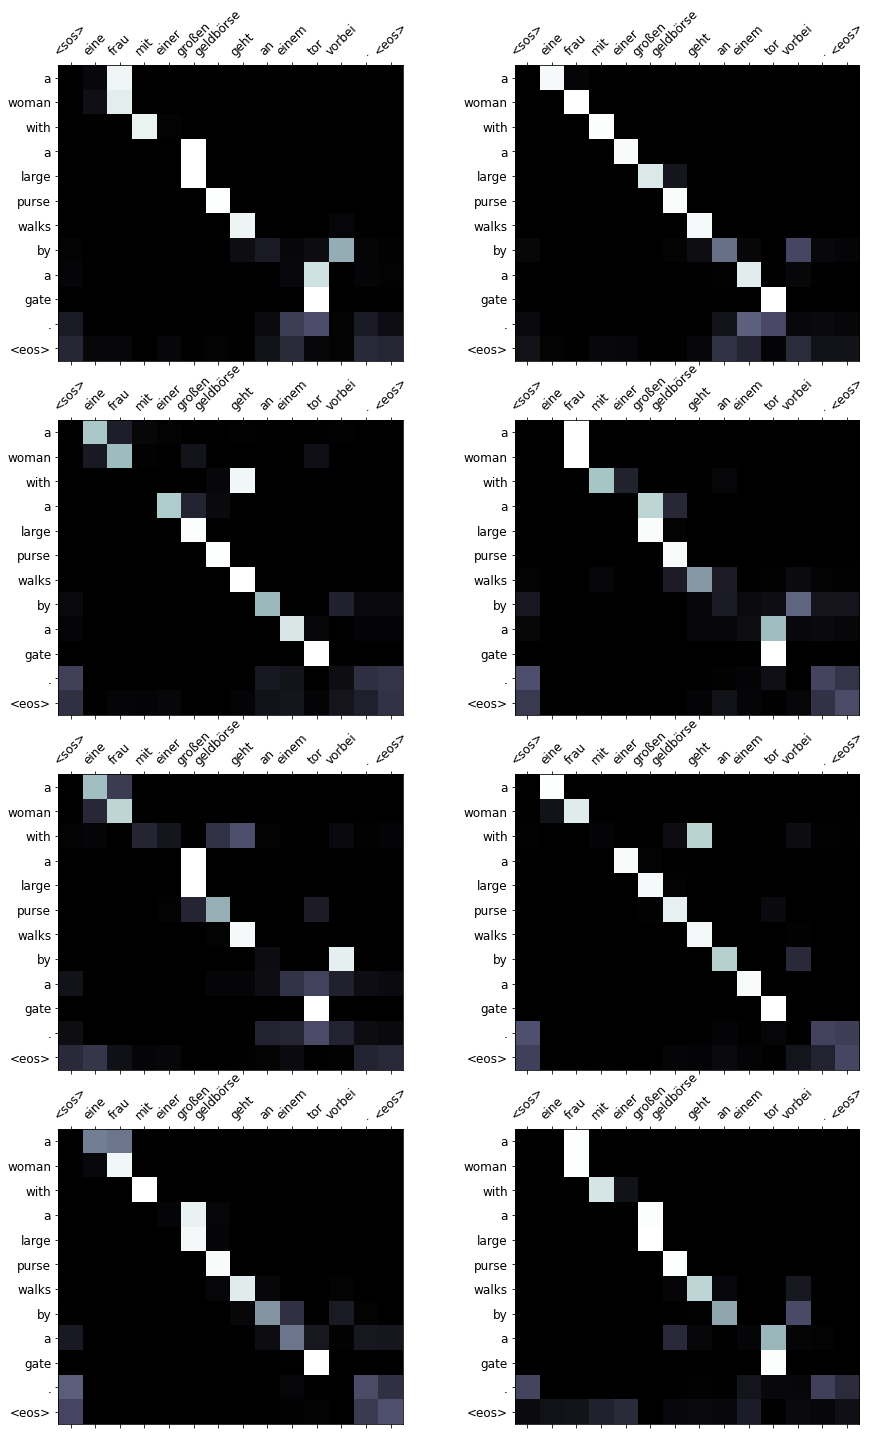

In [ ]:
display_attention(src, translation, attention)

Затем давайте возьмем пример, на котором модель не обучалась, из набора для проверки.

In [ ]:
example_idx = 6

src = vars(valid_data.examples[example_idx])['src']
trg = vars(valid_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['ein', 'brauner', 'hund', 'rennt', 'dem', 'schwarzen', 'hund', 'hinterher', '.']
trg = ['a', 'brown', 'dog', 'is', 'running', 'after', 'the', 'black', 'dog', '.']


Модель переводит это, переключая *is running* на просто *runs*, но это приемлемая замена.

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'brown', 'dog', 'running', 'after', 'the', 'black', 'dog', '.', '<eos>']


Опять же, некоторые направления внимания полностью обращают внимание на "ein", в то время как некоторые не обращают на него внимания. Опять же, при выводе точки и предложения <eos> в прогнозируемом целевом предложении кажется, что большинство направления внимания распределяют свое внимание как на точку, так и на токены `<eos>` в исходном предложении, хотя некоторые, похоже, обращают внимание на токены от начала предложения.

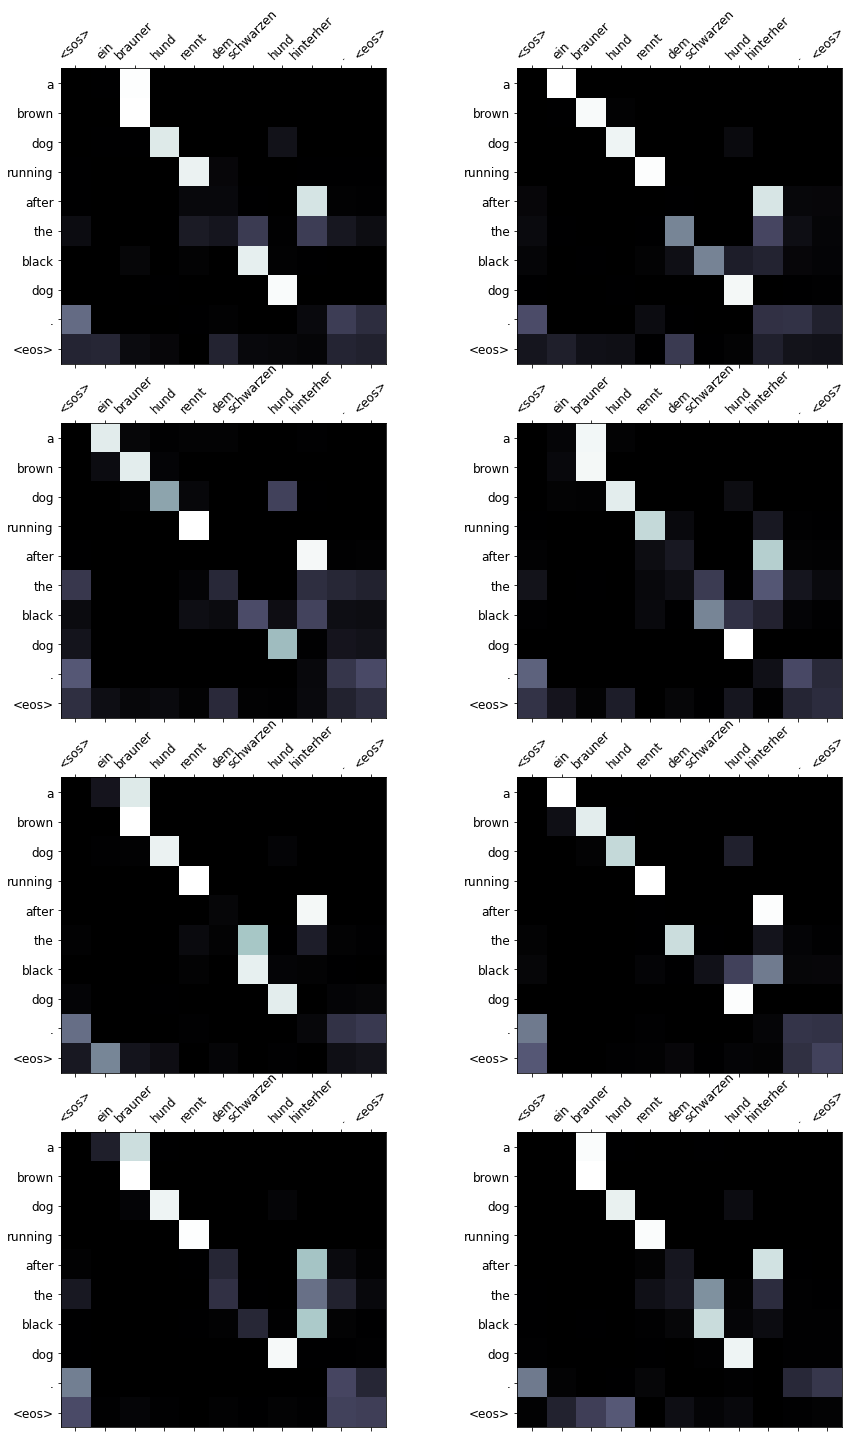

In [ ]:
display_attention(src, translation, attention)

Наконец, мы рассмотрим пример из тестовых данных.

In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

src = ['eine', 'mutter', 'und', 'ihr', 'kleiner', 'sohn', 'genießen', 'einen', 'schönen', 'tag', 'im', 'freien', '.']
trg = ['a', 'mother', 'and', 'her', 'young', 'song', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.']


Прекрасный перевод!

In [ ]:
translation, attention = translate_sentence(src, SRC, TRG, model, device)

print(f'predicted trg = {translation}')

predicted trg = ['a', 'mother', 'and', 'her', 'young', 'son', 'enjoying', 'a', 'beautiful', 'day', 'outside', '.', '<eos>']


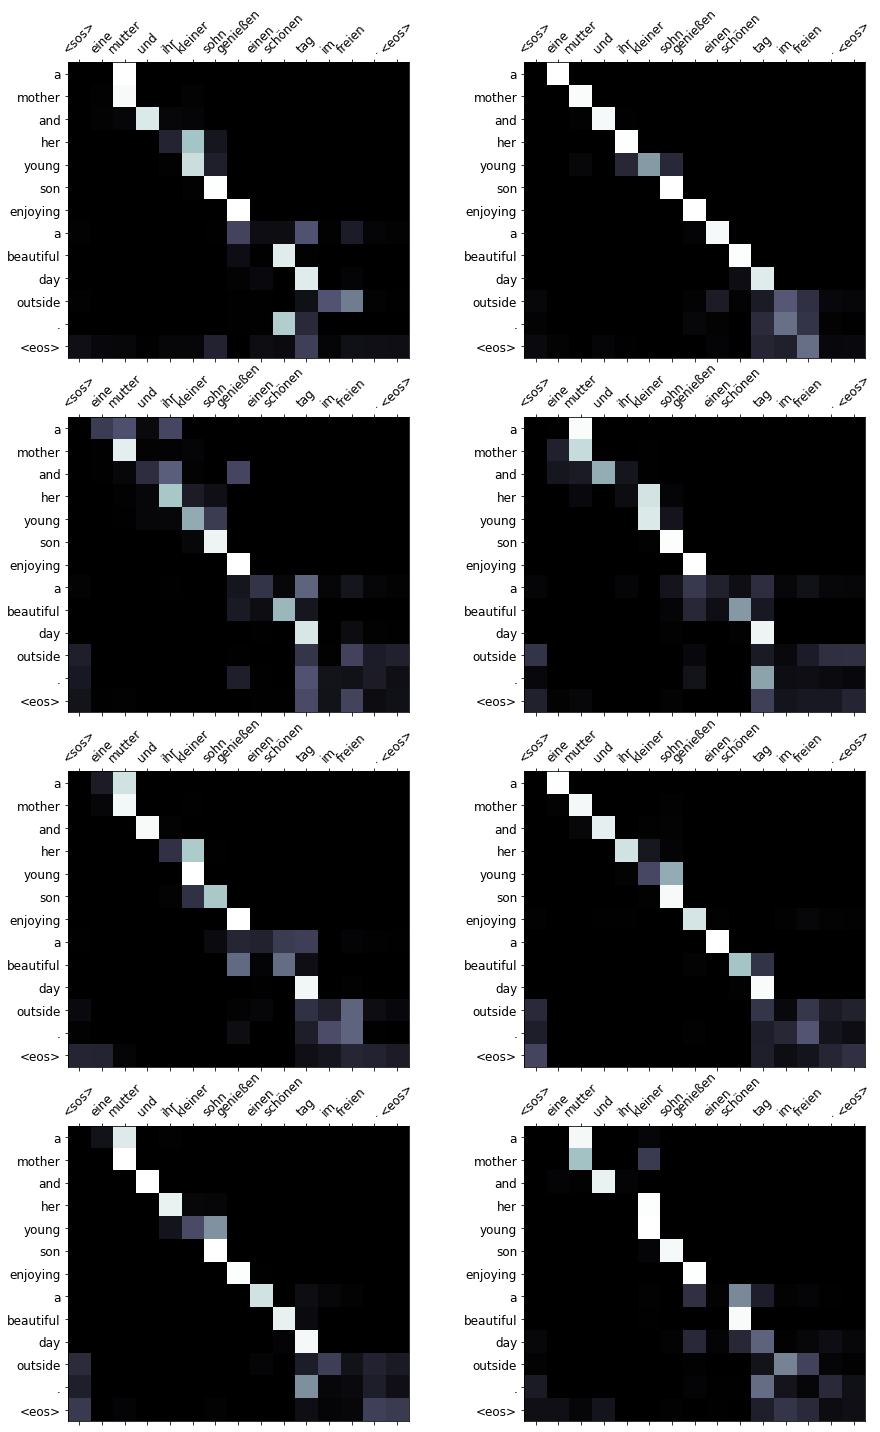

In [ ]:
display_attention(src, translation, attention)

## BLEU

Наконец, мы рассчитываем оценку BLEU для трансформатора.

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

Мы получили оценку BLEU 36,52, что превосходит ~ 34 для свёрточной модели sequence-to-sequence и ~ 28 для модели RNN, основанной на внимании. И все это с наименьшим количеством параметров и самым быстрым временем обучения!

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)

print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 36.10


Поздравляем с окончанием этих уроков! Надеюсь, они были вам полезны.

Если вы обнаружите какие-либо ошибки или захотите задать какие-либо вопросы по поводу какого-либо кода или используемых объяснений, не стесняйтесь отправлять проблему на GitHub, и я постараюсь исправить ее как можно скорее.

## Приложение

Вышеупомянутая функция `calculate_bleu` не оптимизирована. Ниже представлена значительно более быстрая векторизованная версия, которую следует использовать при необходимости. Благодарим за реализацию [@azadyasar](https://github.com/azadyasar).

In [ ]:
def translate_sentence_vectorized(src_tensor, src_field, trg_field, model, device, max_len=50):
    assert isinstance(src_tensor, torch.Tensor)

    model.eval()
    src_mask = model.make_src_mask(src_tensor)

    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)
    # enc_src = [batch_sz, src_len, hid_dim]

    trg_indexes = [[trg_field.vocab.stoi[trg_field.init_token]] for _ in range(len(src_tensor))]
    # Even though some examples might have been completed by producing a <eos> token
    # we still need to feed them through the model because other are not yet finished
    # and all examples act as a batch. Once every single sentence prediction encounters
    # <eos> token, then we can stop predicting.
    translations_done = [0] * len(src_tensor)
    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        pred_tokens = output.argmax(2)[:,-1]
        for i, pred_token_i in enumerate(pred_tokens):
            trg_indexes[i].append(pred_token_i)
            if pred_token_i == trg_field.vocab.stoi[trg_field.eos_token]:
                translations_done[i] = 1
        if all(translations_done):
            break

    # Iterate through each predicted example one by one;
    # Cut-off the portion including the after the <eos> token
    pred_sentences = []
    for trg_sentence in trg_indexes:
        pred_sentence = []
        for i in range(1, len(trg_sentence)):
            if trg_sentence[i] == trg_field.vocab.stoi[trg_field.eos_token]:
                break
            pred_sentence.append(trg_field.vocab.itos[trg_sentence[i]])
        pred_sentences.append(pred_sentence)

    return pred_sentences, attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu_alt(iterator, src_field, trg_field, model, device, max_len = 50):
    trgs = []
    pred_trgs = []
    with torch.no_grad():
        for batch in iterator:
            src = batch.src
            trg = batch.trg
            _trgs = []
            for sentence in trg:
                tmp = []
                # Start from the first token which skips the <start> token
                for i in sentence[1:]:
                    # Targets are padded. So stop appending as soon as a padding or eos token is encountered
                    if i == trg_field.vocab.stoi[trg_field.eos_token] or i == trg_field.vocab.stoi[trg_field.pad_token]:
                        break
                    tmp.append(trg_field.vocab.itos[i])
                _trgs.append([tmp])
            trgs += _trgs
            pred_trg, _ = translate_sentence_vectorized(src, src_field, trg_field, model, device)
            pred_trgs += pred_trg
    return pred_trgs, trgs, bleu_score(pred_trgs, trgs)


## Обучение сети инвертированию предложения

В конце приведу один из моих любимых тестов: тест на инверсию предложения. Очень простая для человека задача (ученики начальной школы обучаются за 10-15 примеров), но, порой, непреодолима для искусственных систем.

Для Google Colab скачаем обучающие последовательности

In [ ]:
!wget https://raw.githubusercontent.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/master/toy_revert/train.csv -P toy_revert
!wget https://raw.githubusercontent.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/master/toy_revert/val.csv -P toy_revert
!wget https://raw.githubusercontent.com/vasiliyeskin/bentrevett-pytorch-seq2seq_ru/master/toy_revert/test.csv -P toy_revert

В начале обучим сеть инверсии и посмотрим на результат.


In [ ]:
SRC = Field(tokenize="spacy",
            init_token='<sos>',
            eos_token='<eos>',
            lower=True, 
            batch_first = True)

TRG = Field(tokenize="spacy",
            init_token='<sos>',
            eos_token='<eos>',
            lower=True, 
            batch_first = True)

data_fields = [('src', SRC), ('trg', TRG)]
# load the dataset in csv format
train_data, valid_data, test_data = TabularDataset.splits(
    path='toy_revert',
    train='train.csv',
    validation='val.csv',
    test='test.csv',
    format='csv',
    fields=data_fields,
    skip_header=True
)

SRC.build_vocab(train_data)
TRG.build_vocab(train_data)

/usr/local/lib/python3.7/dist-packages/torchtext/data/utils.py:123: UserWarning: Spacy model "en" could not be loaded, trying "en_core_web_sm" instead
  warnings.warn(f'Spacy model "{language}" could not be loaded, trying "{OLD_MODEL_SHORTCUTS[language]}" instead')


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

BATCH_SIZE = 32

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     sort_key = lambda x: len(x.src),
     sort_within_batch=True,
     device = device)



################## create DNN Seq2Seq ###############################

INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 64
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM,
              HID_DIM,
              ENC_LAYERS,
              ENC_HEADS,
              ENC_PF_DIM,
              ENC_DROPOUT,
              device)

dec = Decoder(OUTPUT_DIM,
              HID_DIM,
              DEC_LAYERS,
              DEC_HEADS,
              DEC_PF_DIM,
              DEC_DROPOUT,
              device)


SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

####################################################################


####### initial weights
model.apply(initialize_weights);
# print(model)

print(f'The model has {count_parameters(model):,} trainable parameters')

optimizer = optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_IDX)

N_EPOCHS = 30
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):

    start_time = time.time()

    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)

    end_time = time.time()

    epoch_mins, epoch_secs = epoch_time(start_time, end_time)

    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'tut3-model.pt')

    print(f'Epoch: {epoch + 1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

    # writer.add_scalar("Train_loss_average_per_epoch", train_loss, epoch)
    # writer.add_scalar("Validate_loss_average_per_epoch", valid_loss, epoch)

model.load_state_dict(torch.load('tut3-model.pt'))

test_loss = evaluate(model, test_iterator, criterion)

print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')


The model has 562,696 trainable parameters
Epoch: 01 | Time: 0m 9s
	Train Loss: 1.177 | Train PPL:   3.244
	 Val. Loss: 0.915 |  Val. PPL:   2.496
Epoch: 02 | Time: 0m 9s
	Train Loss: 0.969 | Train PPL:   2.634
	 Val. Loss: 0.881 |  Val. PPL:   2.413
Epoch: 03 | Time: 0m 9s
	Train Loss: 0.901 | Train PPL:   2.462
	 Val. Loss: 0.796 |  Val. PPL:   2.216
Epoch: 04 | Time: 0m 9s
	Train Loss: 0.795 | Train PPL:   2.213
	 Val. Loss: 0.555 |  Val. PPL:   1.742
Epoch: 05 | Time: 0m 9s
	Train Loss: 0.664 | Train PPL:   1.943
	 Val. Loss: 0.448 |  Val. PPL:   1.565
Epoch: 06 | Time: 0m 9s
	Train Loss: 0.583 | Train PPL:   1.792
	 Val. Loss: 0.457 |  Val. PPL:   1.579
Epoch: 07 | Time: 0m 9s
	Train Loss: 0.510 | Train PPL:   1.665
	 Val. Loss: 0.247 |  Val. PPL:   1.280
Epoch: 08 | Time: 0m 9s
	Train Loss: 0.452 | Train PPL:   1.572
	 Val. Loss: 0.237 |  Val. PPL:   1.267
Epoch: 09 | Time: 0m 9s
	Train Loss: 0.381 | Train PPL:   1.463
	 Val. Loss: 0.172 |  Val. PPL:   1.188
Epoch: 10 | Time: 0m 

testing with the life example

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 20):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
        
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]

    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):

        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)

        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
from torchtext.data.metrics import bleu_score

def calculate_bleu(data, src_field, trg_field, model, device, max_len = 20):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

src = ['c', 'b', 'd', 'a', 'd', 'b', 'a', 'c', 'c', 'a', 'b', 'c']
trg = ['c', 'b', 'a', 'c', 'c', 'a', 'b', 'd', 'a', 'd', 'b', 'c']
source        = ['c', 'b', 'd', 'a', 'd', 'b', 'a', 'c', 'c', 'a', 'b', 'c']


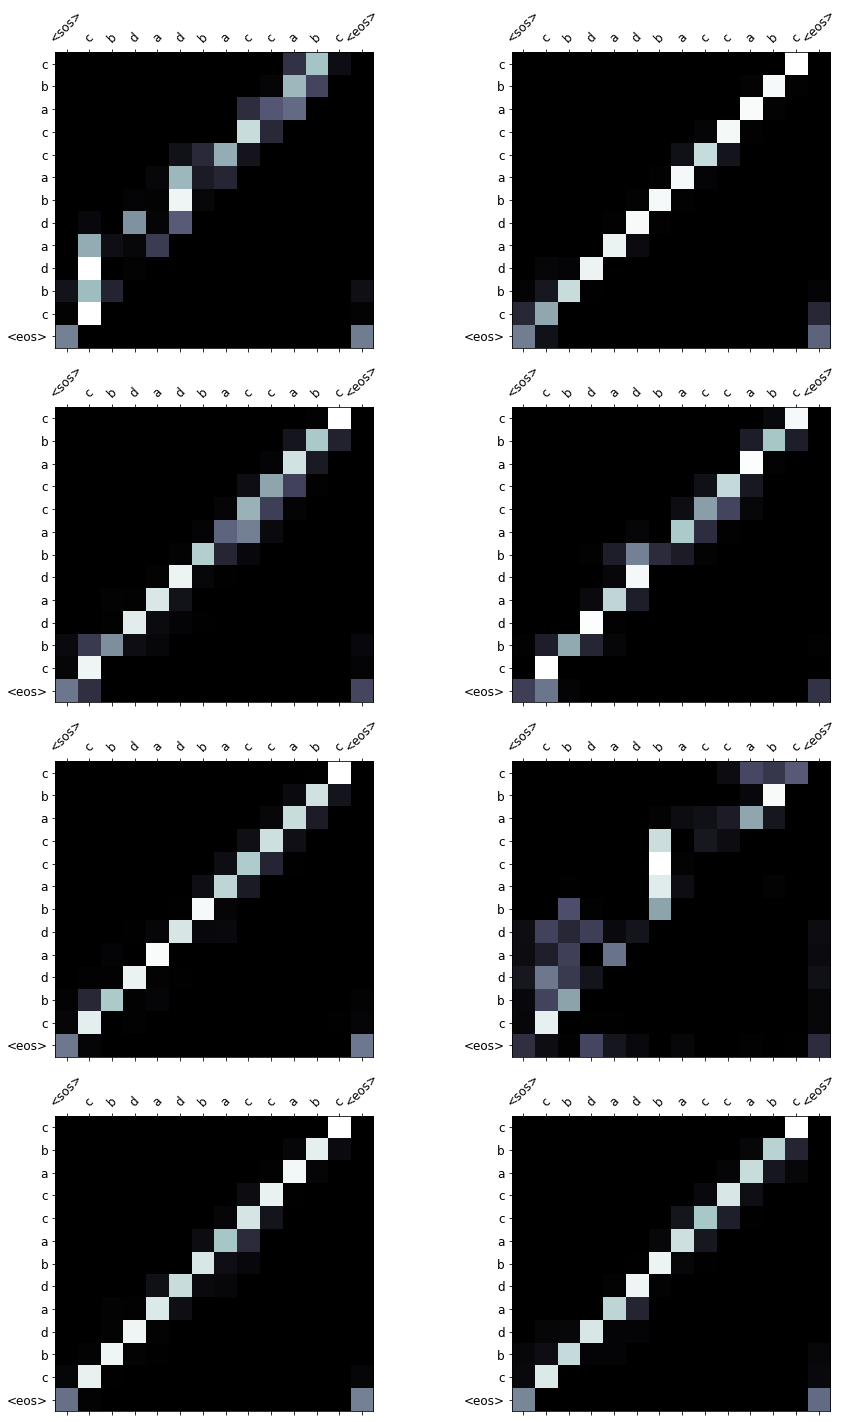

predicted trg = ['c', 'b', 'a', 'c', 'c', 'a', 'b', 'd', 'a', 'd', 'b', 'c', '<eos>']
source        = ['a', 'b', 'c', 'a', 'd']


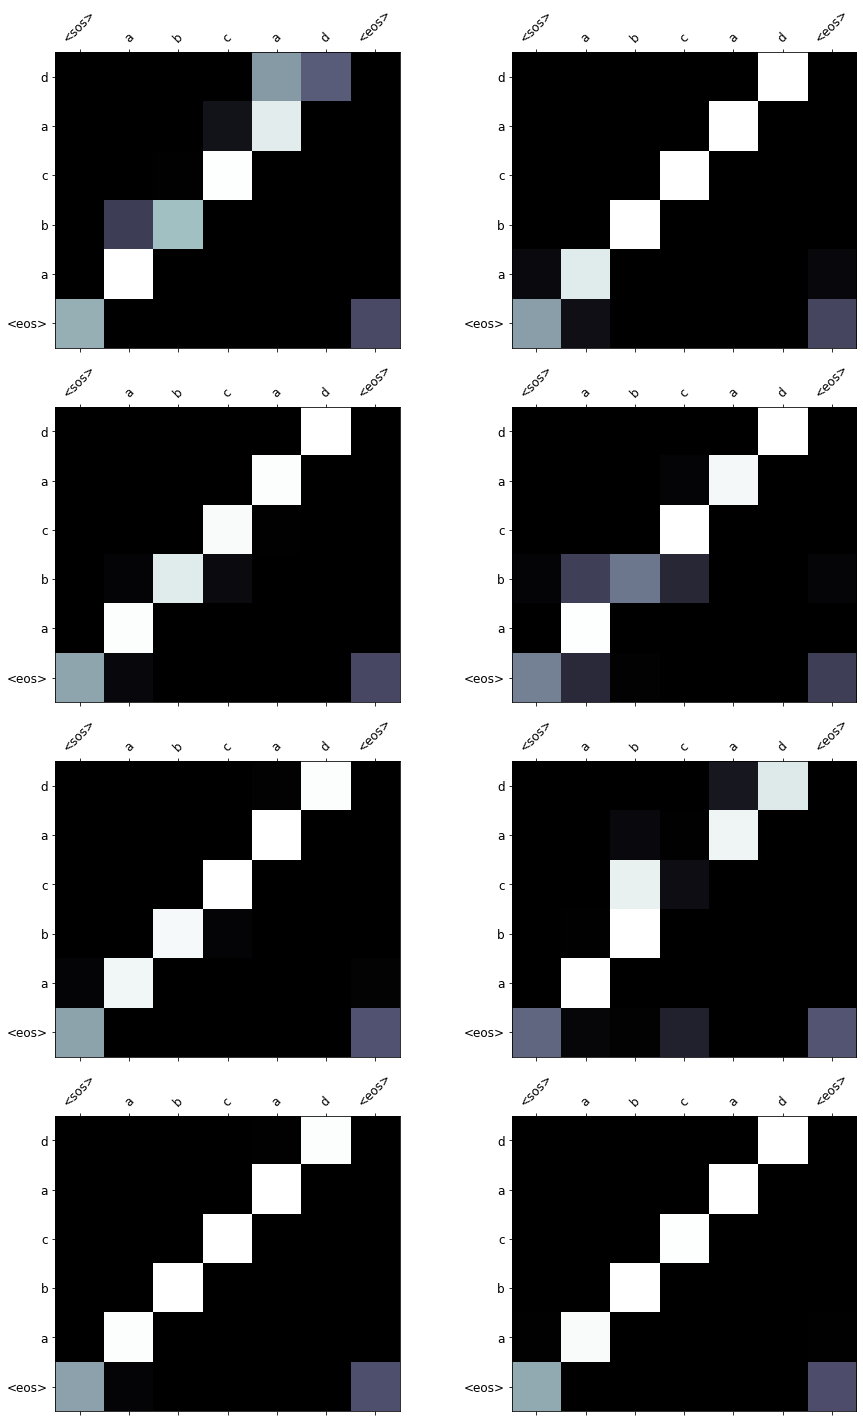

predicted trg = ['d', 'a', 'c', 'b', 'a', '<eos>']
source        = ['d', 'b', 'c', 'd']


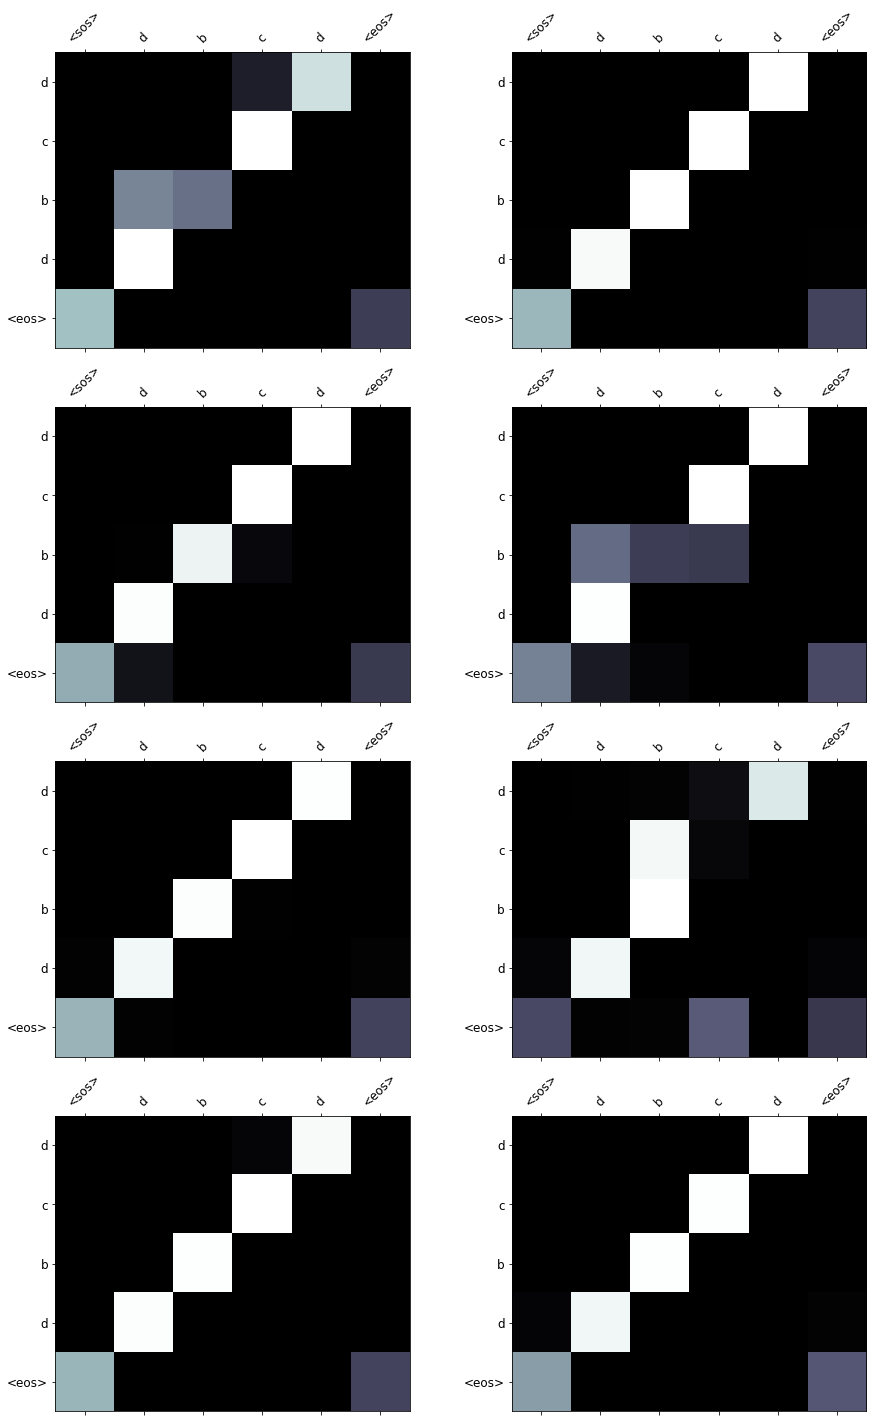

predicted trg = ['d', 'c', 'b', 'd', '<eos>']
source        = ['a', 'a', 'a', 'a', 'd']
predicted trg = ['d', 'a', 'a', 'a', 'a', '<eos>']
source        = ['d', 'b', 'c', 'a']
predicted trg = ['a', 'c', 'b', 'd', '<eos>']
source        = ['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd']
predicted trg = ['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd', '<eos>']
BLEU score = 99.85


In [ ]:
example_idx = 10

src = vars(test_data.examples[example_idx])['src']
trg = vars(test_data.examples[example_idx])['trg']

print(f'src = {src}')
print(f'trg = {trg}')

print(f'source        = {src}')
translation, attention =  translate_sentence(src, SRC, TRG, model, device)
display_attention(src, translation, attention)

print(f'predicted trg = {translation}')

src = ['a', 'b', 'c', 'a', 'd']
print(f'source        = {src}')
translation, attention =  translate_sentence(src, SRC, TRG, model, device)
display_attention(src, translation, attention)
print(f'predicted trg = {translation}')

src = 'd b c d'.split(' ')
print(f'source        = {src}')
translation, attention =  translate_sentence(src, SRC, TRG, model, device)
display_attention(src, translation, attention)
print(f'predicted trg = {translation}')

src = ['a', 'a', 'a', 'a', 'd']
print(f'source        = {src}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['d', 'b', 'c', 'a']
print(f'source        = {src}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')

src = ['d', 'd', 'd', 'd', 'd', 'd', 'd', 'd']
print(f'source        = {src}')
translation, attention = translate_sentence(src, SRC, TRG, model, device)
print(f'predicted trg = {translation}')


bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score * 100:.2f}')